# QODE benchmark

This notebook aimed at the comparison of different Quasi Oppositional Differential Evolution (QODE) algorithms which are implemented in a dev version of PyMoosh (PM) in order to select the best one for the main version.

Benchmarks of the base PM QODE and various QODE are done (two DE versions added for completness), the comparison is made from convergence curves  (averaged and individual, to check that all algoritms converge) and consistency curves.

The problem to solve is to optimize a dielectric mirror, a multilayer structure for which the reflectance for a given wavelength, incidence and polarisation; has to be maximized. For this purpose traditionnal PM functions and classes will be used.

In [1]:
import PyMoosh as PM
import numpy as np
import matplotlib.pyplot as plt
import time
import timeit

Definition of the wavelength, incidence and polarisation; for which the mirror has to be optimized. Definition of the associated cost function and structure. Definition of the geometrical parameter of the mirror, the budget of the optimisation and the number of run of each algoritm.

In [2]:
# The wavelength we are interested in
wav = 600
# The angle of incidence and polarization the structure is intended for
angle = 0 * np.pi / 180
polar = 0 # 0 for TE, 1 for TM

nb_layers = 20 # We want a 30-layer Dielectric mirror
min_lay = 10 # No layer thinner than 10 nm
max_lay = 300 # No layer thicker than 800 nm (half the wavelength)

# Budget of the optimisation
budget = 15000

# Number of run to realize for the benchmark
nb_run=31

# Array of min and max layer thickness.
X_min = np.array([min_lay] * nb_layers)
X_max = np.array([max_lay] * nb_layers)

# The cost function to minimize.
def objective_function(layers, wavelength=wav, angle=angle, polar=polar):
    """
    We want to maximise the reflectance of the structure for the chosen wavelength
    """
    nb_lay = len(layers)//2
    mat = [1, 1.8, 1.4]
    stack = [0] + [1, 2] * nb_lay + [0]
    thickness = [0] + [t for t in layers] + [0]
    structure = PM.Structure(mat, stack, thickness, verbose=False)
    r, t, R, T = PM.coefficient(structure, wavelength, angle, polar)
    return 1-R

Definition of a benchmark function to call on any DE.

In [3]:
def benchmark(algo, f_cout, budget, X_min, X_max, nb_run):
    """
    Function that run the benchmark of the given algoritm and return the array needed to plot convergence, average convergence and consistency curves.

    Args:
        algo (function): the optimisation algoritm to use, the population is set at 30 by default (should be even for QODE)
        f_cout (function): cost function taking a numpy vector as argument
        budget (integer): number of times the cost function can be computed
        X_min (numpy array): lower boundaries of the optimization domain, a vector with the same size as the argument of the cost function
        X_max (numpy array): upper boundaries of the optimization domain
        nb_run (integer): number of run of the algorithm to perform for the benchmark

    Returns:
        dictionnary containing
        - p_all_convergence (numpy array): 2D array with the best cost of each generation for each run
        - np_average_convergence (numpy array): 1D array with the best cost of each generation averaged on all the run
        - np_average_convergence_err (numpy array): 1D error array of np_average_convergence
        - np_last_convergence (numpy array): 1D array of the best (last) cost of each run, sorted from min to max
    """
    all_convergence = []
    start = time.perf_counter()
    for i in range(nb_run):
        best, convergence = algo(f_cout, budget, X_min, X_max)
        all_convergence.append(convergence)
    end = time.perf_counter()
    print(
        f"Average execution time of {algo.__name__}: {(end-start)/nb_run:.6f} seconds"
    )
    # We need to used np.pad in order to have convergence list of the same sizes at the end (the last value is repeted for the shorter lists until reaching the size of the longest)
    # This will bias the mean and std determination ->
    max_len = max(len(sublist) for sublist in all_convergence)
    np_all_convergence = np.array(
        [
            np.pad(sublist, (0, max_len - len(sublist)), mode="edge")
            for sublist in all_convergence
        ]
    )
    np_average_convergence = np.mean(np_all_convergence, axis=0)
    np_average_convergence_err = np.std(np_all_convergence, axis=0, ddof=1)
    np_last_convergence = np.sort(np_all_convergence[:, -1])
    results_dico = {
        "all convergences": np_all_convergence,
        "average convergence": np_average_convergence,
        "average convergence err": np_average_convergence_err,
        "consistency": np_last_convergence,
    }
    return results_dico

Run of the benchmark:

In [4]:
QODE_results=benchmark(PM.QODE, objective_function, budget, X_min, X_max, nb_run)
QODE_V2_results=benchmark(PM.QODE_V2, objective_function, budget, X_min, X_max, nb_run)
QODE_V3_results=benchmark(PM.QODE_V3, objective_function, budget, X_min, X_max, nb_run)
QODE_V4_results=benchmark(PM.QODE_V4, objective_function, budget, X_min, X_max, nb_run)
DE_results=benchmark(PM.differential_evolution, objective_function, budget, X_min, X_max, nb_run)
my_QODE_results=benchmark(PM.variant_ini_QODE, objective_function, budget, X_min, X_max, nb_run)
my_DE_results=benchmark(PM.variant_ini_differential_evolution, objective_function, budget, X_min, X_max, nb_run)

Average execution time of QODE: 2.997715 seconds
Average execution time of QODE_V2: 3.000951 seconds
Average execution time of QODE_V3: 3.102797 seconds
Average execution time of QODE_V4: 2.939314 seconds
Average execution time of differential_evolution: 2.995484 seconds
Average execution time of variant_ini_QODE: 2.957071 seconds
Average execution time of variant_ini_differential_evolution: 2.975909 seconds


Plot of the results

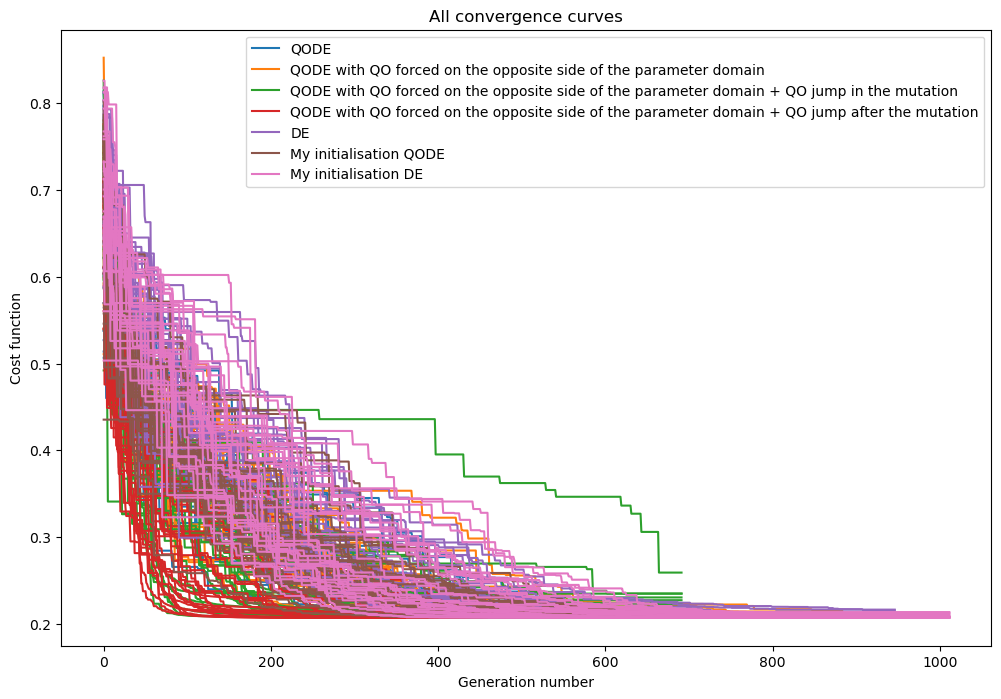

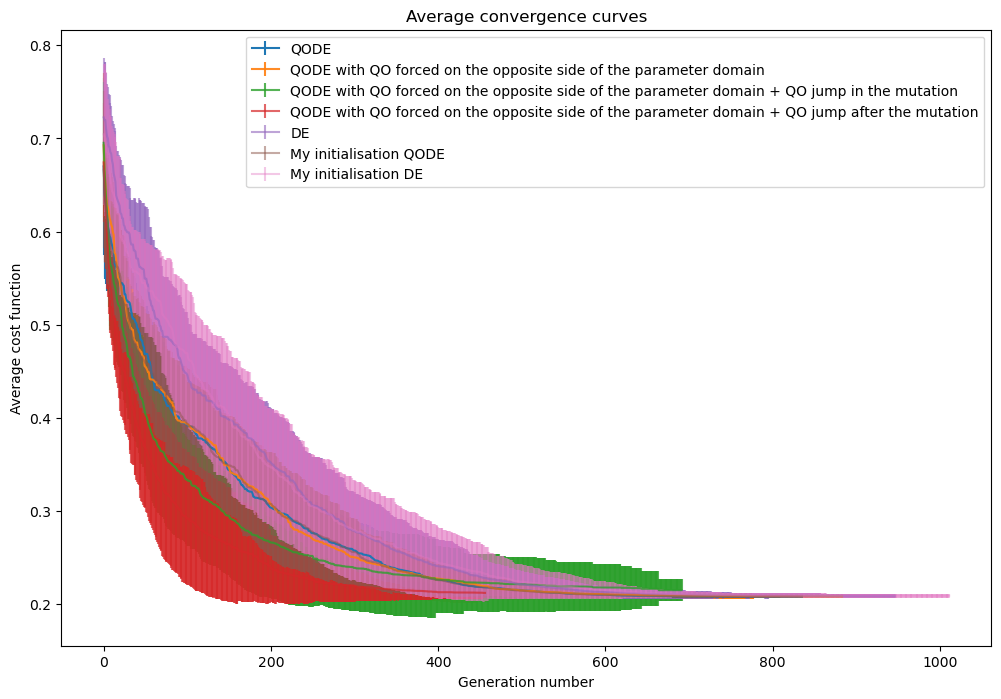

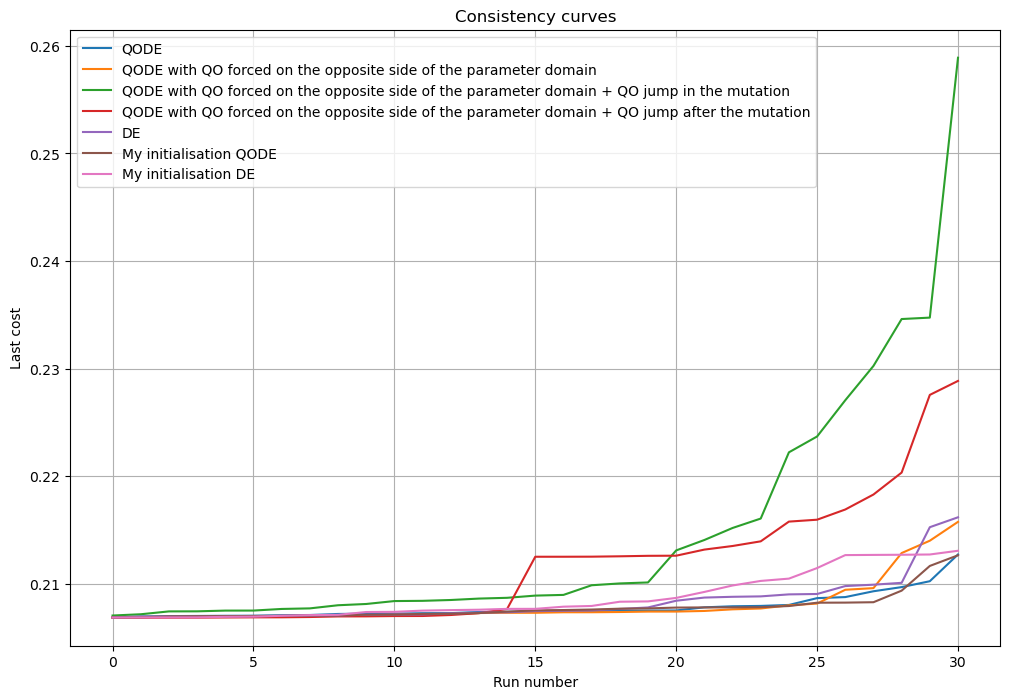

In [5]:
plt.figure(figsize=(12,8))
plt.title("All convergence curves")
for row in QODE_results["all convergences"]:
    plt.plot(row, color="#1f77b4")
for row in QODE_V2_results["all convergences"]:
    plt.plot(row, color="#ff7f0e")
for row in QODE_V3_results["all convergences"]:
    plt.plot(row, color="#2ca02c")
for row in QODE_V4_results["all convergences"]:
    plt.plot(row, color="#d62728")
for row in DE_results["all convergences"]:
    plt.plot(row, color="#9467bd")
for row in my_QODE_results["all convergences"]:
    plt.plot(row, color="#8c564b")
for row in my_DE_results["all convergences"]:
    plt.plot(row, color="#e377c2")
plt.plot([], [], color='#1f77b4', label='QODE')
plt.plot([], [], color='#ff7f0e', label='QODE with QO forced on the opposite side of the parameter domain')
plt.plot([], [], color='#2ca02c', label='QODE with QO forced on the opposite side of the parameter domain + QO jump in the mutation')
plt.plot([], [], color='#d62728', label='QODE with QO forced on the opposite side of the parameter domain + QO jump after the mutation')
plt.plot([], [], color='#9467bd', label='DE')
plt.plot([], [], color='#8c564b', label='My initialisation QODE')
plt.plot([], [], color='#e377c2', label='My initialisation DE')
plt.xlabel("Generation number")
plt.ylabel("Cost function")
plt.legend();

plt.figure(figsize=(12,8))
plt.title("Average convergence curves")
plt.errorbar(x=np.arange(0,len(QODE_results["average convergence"])),y=QODE_results["average convergence"], yerr=QODE_results["average convergence err"],label="QODE")
plt.errorbar(x=np.arange(0,len(QODE_V2_results["average convergence"])),y=QODE_V2_results["average convergence"], yerr=QODE_V2_results["average convergence err"],label="QODE with QO forced on the opposite side of the parameter domain",alpha=0.9)
plt.errorbar(x=np.arange(0,len(QODE_V3_results["average convergence"])),y=QODE_V3_results["average convergence"], yerr=QODE_V3_results["average convergence err"],label="QODE with QO forced on the opposite side of the parameter domain + QO jump in the mutation",alpha=0.8)
plt.errorbar(x=np.arange(0,len(QODE_V4_results["average convergence"])),y=QODE_V4_results["average convergence"], yerr=QODE_V4_results["average convergence err"],label="QODE with QO forced on the opposite side of the parameter domain + QO jump after the mutation",alpha=0.7)
plt.errorbar(x=np.arange(0,len(DE_results["average convergence"])),y=DE_results["average convergence"], yerr=DE_results["average convergence err"],label="DE",alpha=0.6)
plt.errorbar(x=np.arange(0,len(my_QODE_results["average convergence"])),y=my_QODE_results["average convergence"], yerr=my_QODE_results["average convergence err"],label="My initialisation QODE",alpha=0.5)
plt.errorbar(x=np.arange(0,len(my_DE_results["average convergence"])),y=my_DE_results["average convergence"], yerr=my_DE_results["average convergence err"],label="My initialisation DE",alpha=0.4)
plt.xlabel("Generation number")
plt.ylabel("Average cost function")
plt.legend();

plt.figure(figsize=(12,8))
plt.title("Consistency curves")
plt.plot(QODE_results["consistency"],label="QODE")
plt.plot(QODE_V2_results["consistency"],label="QODE with QO forced on the opposite side of the parameter domain")
plt.plot(QODE_V3_results["consistency"],label="QODE with QO forced on the opposite side of the parameter domain + QO jump in the mutation")
plt.plot(QODE_V4_results["consistency"],label="QODE with QO forced on the opposite side of the parameter domain + QO jump after the mutation")
plt.plot(DE_results["consistency"],label="DE")
plt.plot(my_QODE_results["consistency"],label="My initialisation QODE")
plt.plot(my_DE_results["consistency"],label="My initialisation DE")
plt.grid()
plt.xlabel("Run number")
plt.ylabel("Last cost")
plt.legend();


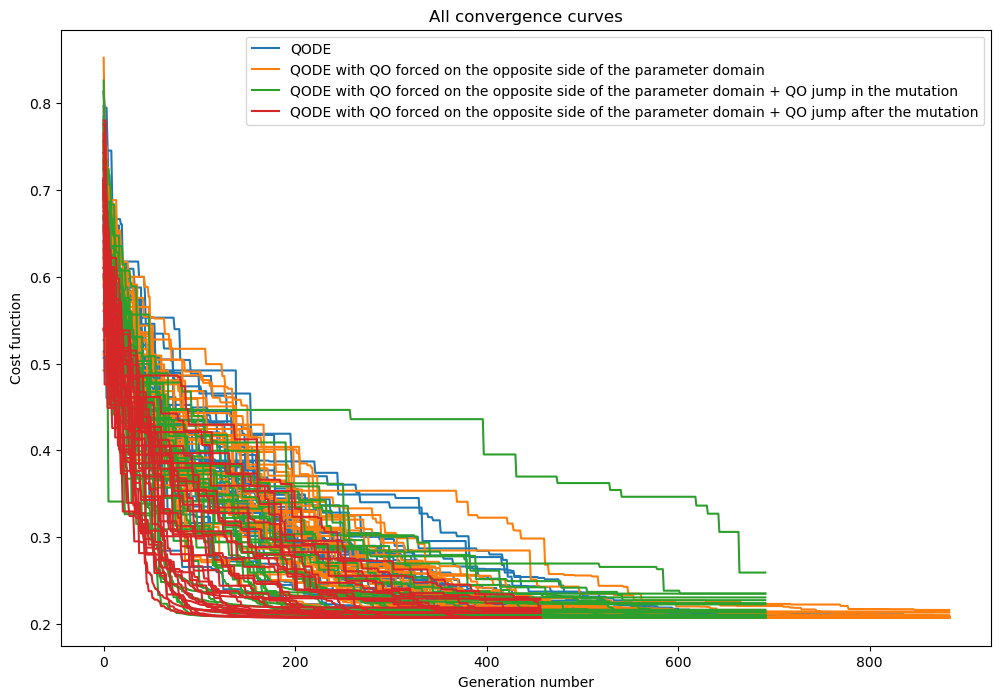

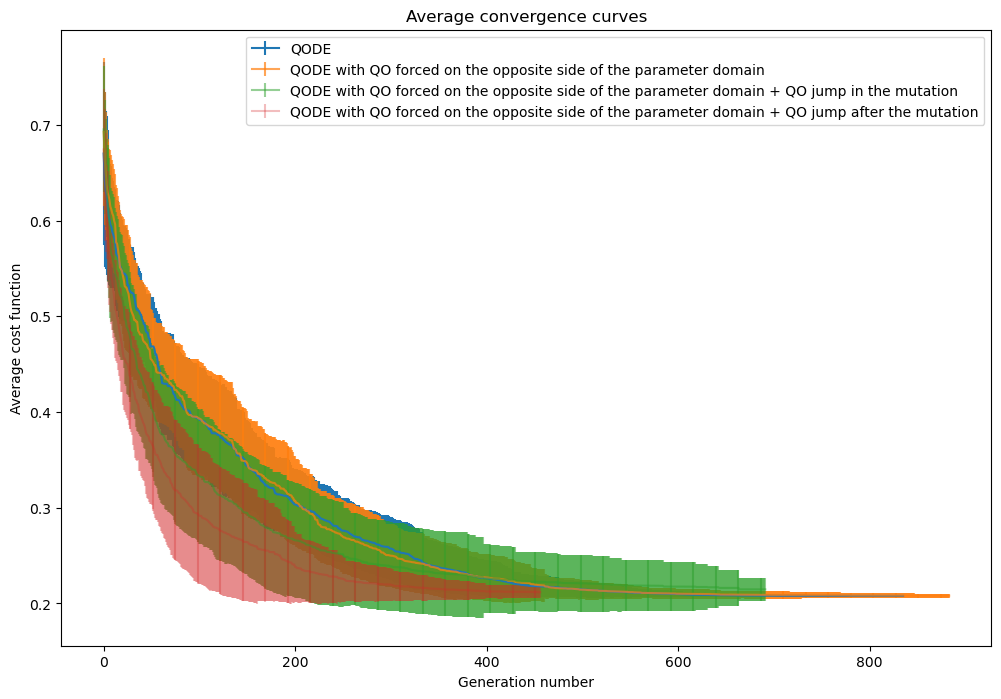

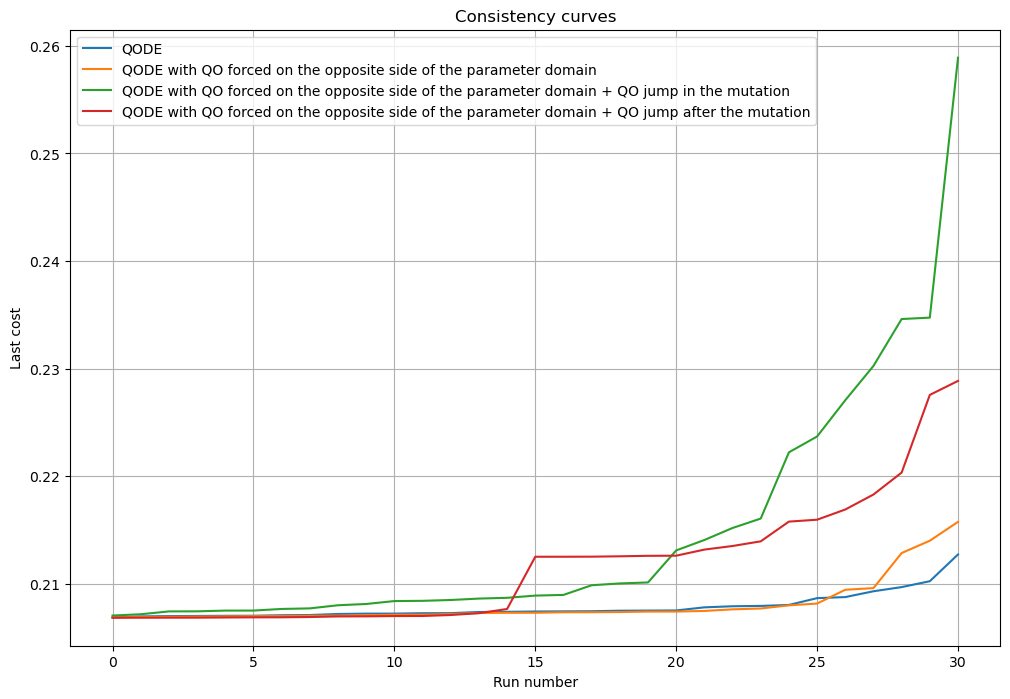

In [6]:
plt.figure(figsize=(12,8))
plt.title("All convergence curves")
for row in QODE_results["all convergences"]:
    plt.plot(row, color="#1f77b4")
for row in QODE_V2_results["all convergences"]:
    plt.plot(row, color="#ff7f0e")
for row in QODE_V3_results["all convergences"]:
    plt.plot(row, color="#2ca02c")
for row in QODE_V4_results["all convergences"]:
    plt.plot(row, color="#d62728")
plt.plot([], [], color='#1f77b4', label='QODE')
plt.plot([], [], color='#ff7f0e', label='QODE with QO forced on the opposite side of the parameter domain')
plt.plot([], [], color='#2ca02c', label='QODE with QO forced on the opposite side of the parameter domain + QO jump in the mutation')
plt.plot([], [], color='#d62728', label='QODE with QO forced on the opposite side of the parameter domain + QO jump after the mutation')
plt.xlabel("Generation number")
plt.ylabel("Cost function")
plt.legend();

plt.figure(figsize=(12,8))
plt.title("Average convergence curves")
plt.errorbar(x=np.arange(0,len(QODE_results["average convergence"])),y=QODE_results["average convergence"], yerr=QODE_results["average convergence err"],label="QODE")
plt.errorbar(x=np.arange(0,len(QODE_V2_results["average convergence"])),y=QODE_V2_results["average convergence"], yerr=QODE_V2_results["average convergence err"],label="QODE with QO forced on the opposite side of the parameter domain",alpha=0.7)
plt.errorbar(x=np.arange(0,len(QODE_V3_results["average convergence"])),y=QODE_V3_results["average convergence"], yerr=QODE_V3_results["average convergence err"],label="QODE with QO forced on the opposite side of the parameter domain + QO jump in the mutation",alpha=0.5)
plt.errorbar(x=np.arange(0,len(QODE_V4_results["average convergence"])),y=QODE_V4_results["average convergence"], yerr=QODE_V4_results["average convergence err"],label="QODE with QO forced on the opposite side of the parameter domain + QO jump after the mutation",alpha=0.3)
plt.xlabel("Generation number")
plt.ylabel("Average cost function")
plt.legend();

plt.figure(figsize=(12,8))
plt.title("Consistency curves")
plt.plot(QODE_results["consistency"],label="QODE")
plt.plot(QODE_V2_results["consistency"],label="QODE with QO forced on the opposite side of the parameter domain")
plt.plot(QODE_V3_results["consistency"],label="QODE with QO forced on the opposite side of the parameter domain + QO jump in the mutation")
plt.plot(QODE_V4_results["consistency"],label="QODE with QO forced on the opposite side of the parameter domain + QO jump after the mutation")
plt.grid()
plt.xlabel("Run number")
plt.ylabel("Last cost")
plt.legend();